# Time-series to image transformation for photometric light curves
We aim to classify photometric transient events with an image classifier. To achieve this we first compute gramian angular field, and markov transition field transformations converting the time series data into an image. We do this for each wavelength band in the dataset (ugrizy). This results in a 12 channel image which we limit to 40 by 40 pixels through zero-padding and downsampling if needed.

See more here about the initial challenge here (https://www.kaggle.com/competitions/PLAsTiCC-2018)

In [1]:
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Dataset

# Other
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

# Matt's standard plot style
import matplotlib as mpl
mpl.rcParams["xtick.top"] = True
mpl.rcParams["ytick.right"] = True
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.major.size"] = 5
mpl.rcParams["xtick.minor.size"] = 2.5
mpl.rcParams["ytick.major.size"] = 5
mpl.rcParams["ytick.minor.size"] = 2.5
mpl.rcParams["xtick.major.width"] = 1
mpl.rcParams["xtick.minor.width"] = 0.5
mpl.rcParams["ytick.major.width"] = 1
mpl.rcParams["ytick.minor.width"] = 0.5
mpl.rcParams["axes.linewidth"] = 2
mpl.rcParams["font.family"] = "serif"


In [2]:
# add google drive access
drive.mount('/content/drive')   # follow the auth link

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Training hyperparameters (at the start is a personal preference choice)
BATCH_SIZE = 128
LEARNING_RATE = 0.01
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-4

In [4]:
# I like to try to have all my function/class definitions at the start if possible, just again a personal preference
def get_accuracy(logits, labels):
    """Return fraction correct in [0,1]"""
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)              # actual batch size (handles last small batch)
    return correct / total

class NPZDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class NumpyCHWToTensor:
    def __call__(self, x):
        import torch, numpy as np
        if isinstance(x, np.ndarray):
            t = torch.from_numpy(x)
        else:
            t = x
        assert t.ndim == 3, f"expect [C,H,W], got {t.shape}"
        # if someone passed HWC by mistake, fix it:
        if t.shape[0] not in (1,3,12) and t.shape[-1] in (1,3,12):
            t = t.permute(2,0,1)  # HWC -> CHW
        return t.float()

def compute_mean_std_per_channel(dataset, batch_size=64, num_workers=2):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    C = None
    n_pixels = 0
    mean = None
    M2 = None  # running variance helper

    for imgs, _ in loader:                 # imgs: [B,C,H,W]
        assert imgs.ndim == 4, f"Expected [B,C,H,W], got {tuple(imgs.shape)}"
        B, c, H, W = imgs.shape
        if C is None:
            C = c
            mean = imgs.new_zeros(C)
            M2   = imgs.new_zeros(C)

        x = imgs.view(B, C, -1)            # [B,C,N]
        batch_mean = x.mean(dim=(0,2))     # [C]
        batch_var  = x.var (dim=(0,2), unbiased=False)  # [C]
        m = B * H * W

        if n_pixels == 0:
            mean = batch_mean
            M2   = batch_var * m
            n_pixels = m
        else:
            delta = batch_mean - mean
            total = n_pixels + m
            mean = mean + delta * (m / total)
            M2   = M2 + batch_var * m + (delta**2) * (n_pixels*m/total)
            n_pixels = total

    std = (M2 / max(n_pixels, 1)).sqrt()
    return mean.cpu(), std.cpu()

# create label for object class used later
label_dict = {90: 'SNIa',
              67: 'SNIa-91bg',
              52: 'SNIax',
              42: 'SNII',
              62: 'SNIbc',
              95: 'SLSN-I',
              15: 'TDE',
              64: 'KN',
              88: 'AGN',
              92: 'RRL',
              65: 'M-dwarf',
              16: 'EB',
              53: 'Mira',
              6: r'$\mu$-Lens',
              }

In [5]:
# let us load in the raw data
data = np.load('/content/drive/MyDrive/training-data/gaf-mtf-training_images_labels.npz', allow_pickle=True)
X = data['X']
X = X.astype('float32')
y = data['y']
class_names = data['class_names']
print(f"shape of images {X.shape}")
print(f"shape of class labels {y.shape}")

shape of images (7848, 40, 40, 12)
shape of class labels (7848,)


In [6]:
# Convert labels to numpy if needed
y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# Use label_dict keys (sorted for reproducibility) as the source of truth
unique_labels = sorted(label_dict.keys())  # preserves stable numeric order
label2idx = {lab: i for i, lab in enumerate(unique_labels)}
idx2label = {i: lab for lab, i in label2idx.items()}
num_classes = len(unique_labels)

# Remap y using the fixed mapping
y_mapped_np = np.vectorize(label2idx.get)(y_np)
y = torch.tensor(y_mapped_np, dtype=torch.long)

# Class names aligned to new indices
class_names = [label_dict[idx2label[i]] for i in range(num_classes)]

In [7]:
# now transform the raw data into a dataset format and calculate mean and std for normalization
raw_train = NPZDataset(X, y, transform=NumpyCHWToTensor())
mean, std = compute_mean_std_per_channel(raw_train)

# now make a fresh dataset, with a train/test split and normalize and perform some augmentations
dataset = NPZDataset(X, y)

# Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

# Define transforms
train_transform = transforms.Compose([
    NumpyCHWToTensor(),
    transforms.RandomResizedCrop(40, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

test_transform = transforms.Compose([
    NumpyCHWToTensor(),
    transforms.CenterCrop(40),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# Assign transforms dynamically
trainset.dataset.transform = train_transform
testset.dataset.transform = test_transform

# finally we create our training and test iterators
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [8]:
# check things are in the dimensions we expect
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([128, 12, 40, 40])
Image label dimensions: torch.Size([128])


## Exploring the Data
It is always good to make sure things look right

Image shape: torch.Size([12, 40, 40])
Label: 11


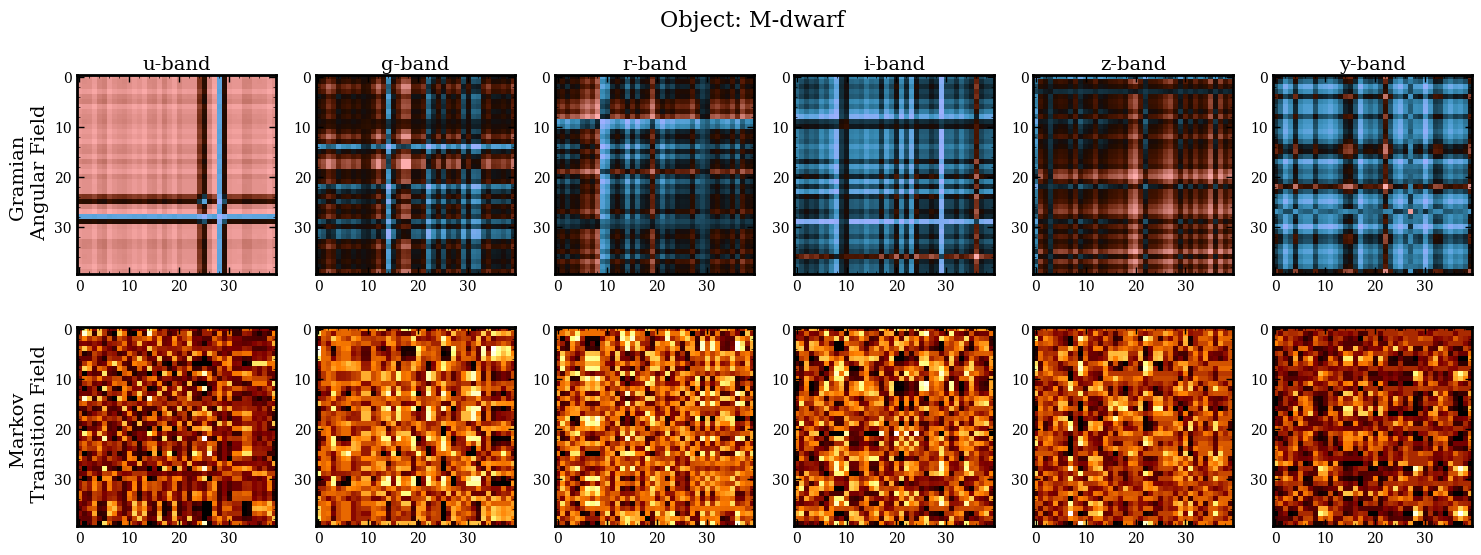

In [9]:
# pick an index
idx = 100
image, label = trainset[idx]
print("Image shape:", image.shape)
print("Label:", y[idx].item())

# ensure tensor is detached and on CPU
image = image.cpu() if image.is_cuda else image

# define labels
band_labels = ["u-band", "g-band", "r-band", "i-band", "z-band", "y-band"]

# create 2x6 grid
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.reshape(2, 6)

for row in range(2):
    for col in range(6):
        ch = row * 6 + col
        ax = axes[row, col]
        # add column labels (bands)
        if row == 0:
          ax.set_title(band_labels[col], fontsize=14, pad=4)
          ax.imshow(image[ch].numpy(), cmap='berlin')
          if col == 0:
            ax.set_ylabel("Gramian \n Angular Field", fontsize=14)
        else:
          ax.imshow(image[ch].numpy(), cmap='afmhot')
          if col == 0:
            ax.set_ylabel("Markov \n Transition Field", fontsize=14)



# main title
fig.suptitle(f'Object: {class_names[label]}', fontsize=16)
plt.show()


### CNN Model Description

We use a compact convolutional neural network tailored to 12-channel inputs. The backbone comprises three 3×3 convolutional stages with Batch Normalization and ReLU activations; each stage is followed by 2×2 max-pooling to progressively reduce spatial resolution. Spatial Dropout (`Dropout2d`) after the first two pooling layers regularizes early feature maps. The final convolutional output (128 channels) is flattened and passed through a 256-unit fully connected layer with dropout before a final linear classifier that outputs logits for `num_classes`. The model is trained with cross-entropy loss and Adam, using per-channel normalization and lightweight data augmentation (random resized crop, horizontal flip, and small rotations). This design balances capacity and regularization for small 40×40 inputs while preserving interpretability of the feature hierarchy.



In [10]:
class MyModel(nn.Module):
    def __init__(self, num_classes=10, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2,2)
        self.drop2d = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(128*5*5, 256)
        self.drop = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)


This is useful for CUDA/GPU debugging, sometimes errors are just due to not pushing things to correct devices.

In [11]:
# labels remapped earlier -> y_mapped
num_classes = int(len(np.unique(y)))

# model on CPU sanity check
model = MyModel(num_classes=num_classes).cpu()
images, labels = next(iter(trainloader))
print('shapes:', images.shape, labels.shape)
print('label range:', labels.min().item(), labels.max().item())

with torch.no_grad():
    logits = model(images.float())
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(logits, labels.long())
print('CPU forward/loss OK')

# now go to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
images = images.to(device).float()
labels = labels.to(device).long()
logits = model(images)
loss = criterion(logits, labels)
loss.backward()
print('GPU step OK')

shapes: torch.Size([128, 12, 40, 40]) torch.Size([128])
label range: 0 13
CPU forward/loss OK
GPU step OK


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model.

In [12]:
# instantiate the model class, optimizer, and create a learning rate schedule
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # ADAM or Stochastic Gradient Descent (SGD)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(trainloader), epochs=NUM_EPOCHS
)

Now let us train our model

In [13]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for images, labels in trainloader:
        images = images.to(device).float()
        labels = labels.to(device).long()

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # if using OneCycleLR

        # accumulate sample-accurate stats
        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(trainloader) if len(trainloader) else 0.0
    epoch_acc = running_correct / total_samples if total_samples else 0.0
    print(f"Epoch: {epoch} | Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc*100:.2f}%")


Epoch: 0 | Loss: 2.1135 | Train Accuracy: 28.93%
Epoch: 1 | Loss: 1.9032 | Train Accuracy: 35.55%
Epoch: 2 | Loss: 1.7316 | Train Accuracy: 40.17%
Epoch: 3 | Loss: 1.7250 | Train Accuracy: 40.90%
Epoch: 4 | Loss: 1.7053 | Train Accuracy: 41.26%
Epoch: 5 | Loss: 1.7133 | Train Accuracy: 40.28%
Epoch: 6 | Loss: 1.6945 | Train Accuracy: 41.43%
Epoch: 7 | Loss: 1.6101 | Train Accuracy: 43.61%
Epoch: 8 | Loss: 1.5941 | Train Accuracy: 44.81%
Epoch: 9 | Loss: 1.5631 | Train Accuracy: 46.65%
Epoch: 10 | Loss: 1.5252 | Train Accuracy: 46.70%
Epoch: 11 | Loss: 1.4776 | Train Accuracy: 48.66%
Epoch: 12 | Loss: 1.4487 | Train Accuracy: 49.43%
Epoch: 13 | Loss: 1.4056 | Train Accuracy: 51.27%
Epoch: 14 | Loss: 1.3717 | Train Accuracy: 52.10%
Epoch: 15 | Loss: 1.3597 | Train Accuracy: 52.15%
Epoch: 16 | Loss: 1.3729 | Train Accuracy: 51.91%
Epoch: 17 | Loss: 1.3887 | Train Accuracy: 52.85%
Epoch: 18 | Loss: 1.3515 | Train Accuracy: 52.74%
Epoch: 19 | Loss: 1.2755 | Train Accuracy: 54.65%
Epoch: 20 

Now, training performance is one thing, but we really care about test performance, so let us run our model (in evalutate mode to remove dropout) and see how accurate we are on the unseen test set.

In [14]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device).float()
        labels = labels.to(device).long()
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total if test_total else 0.0
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 57.26%


## Analysis tools
A useful visual tool to inspect what is going on with multi-class classification algorithms is the classic confusion matrix. This lets us see what classes we are correctly prediction, which we are not, and what classes we are assigning when we get our prediction wrong.

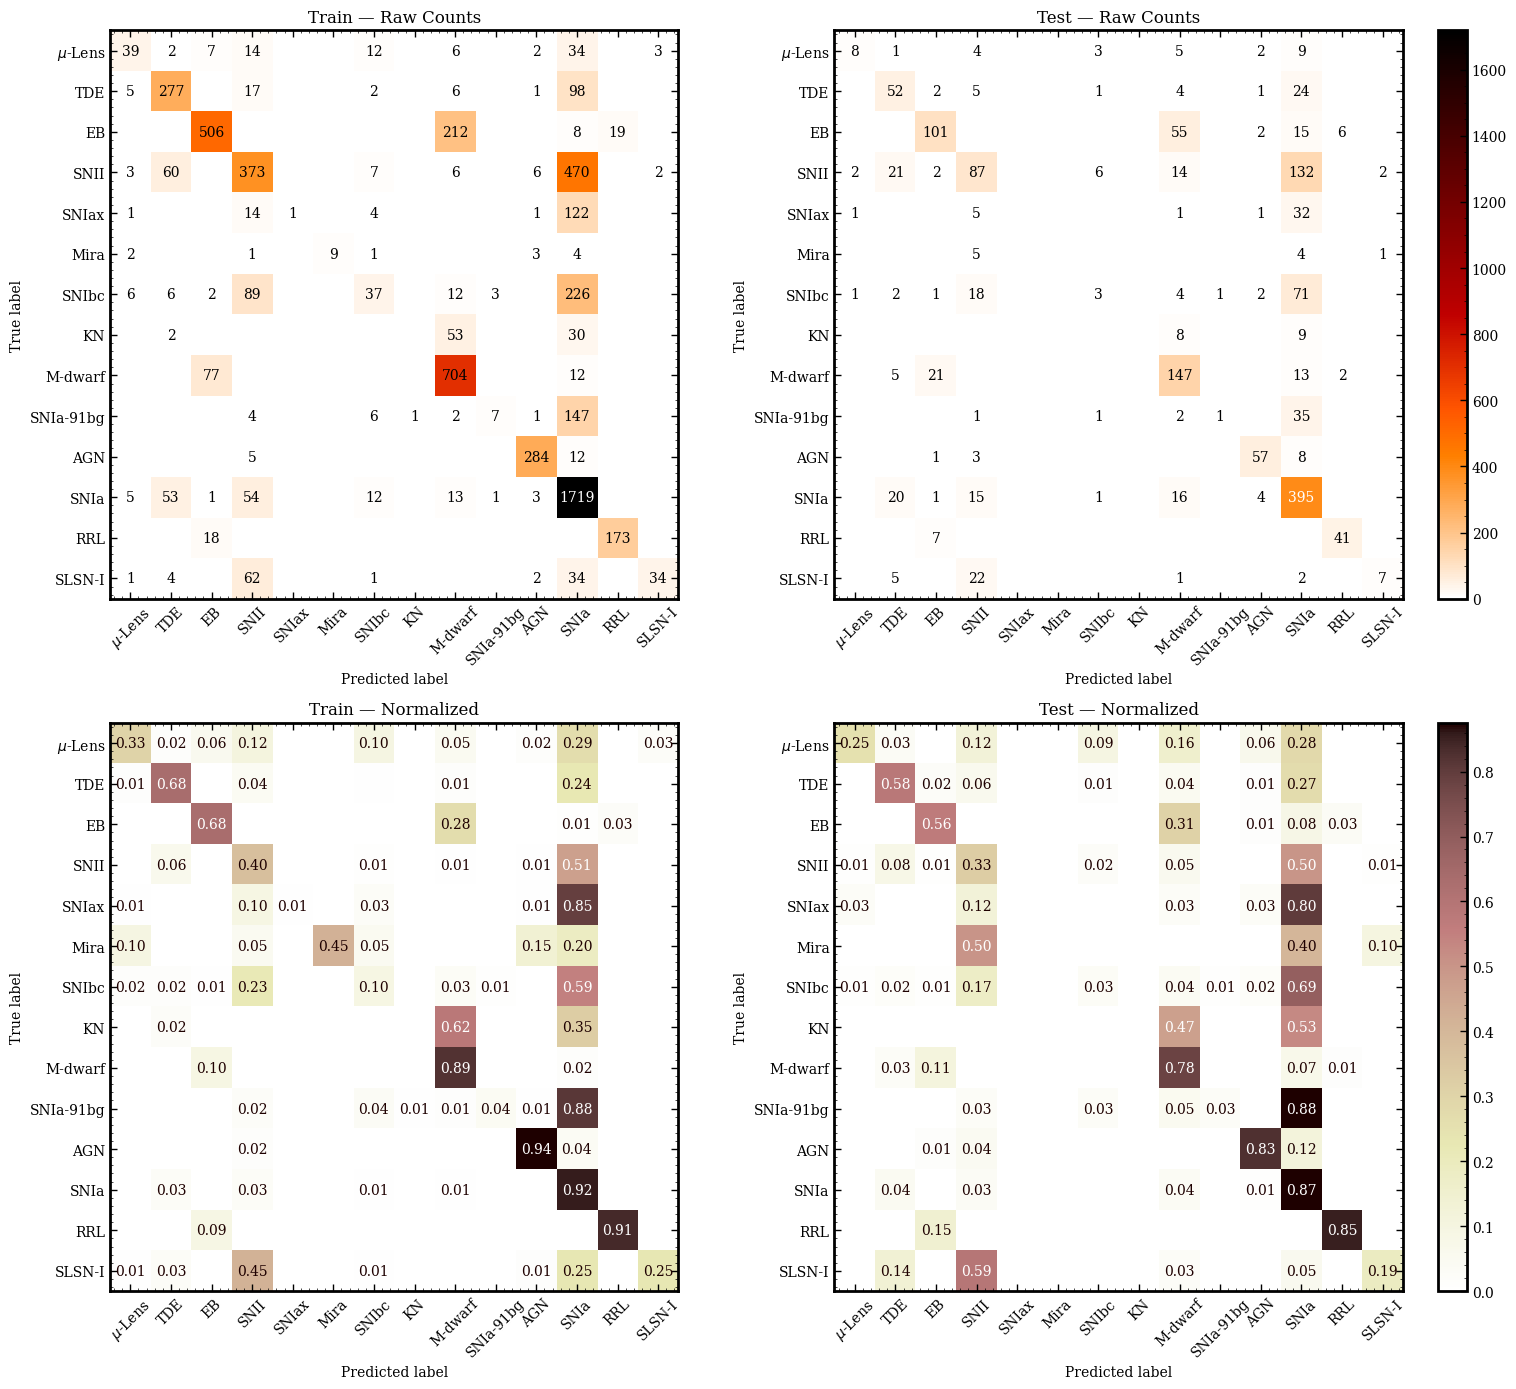

In [15]:

# the test predictions
all_true, all_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_true.append(labels.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true_test = np.concatenate(all_true)
y_pred_test = np.concatenate(all_pred)

# the train predictions
all_true, all_pred = [], []
with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_true.append(labels.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true_train = np.concatenate(all_true)
y_pred_train = np.concatenate(all_pred)

# create confusion matrices
labels_order = list(range(num_classes))
cm_test  = confusion_matrix(y_true_test,  y_pred_test,  labels=labels_order)
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=labels_order)
cm_test_norm  = confusion_matrix(y_true_test,  y_pred_test,  labels=labels_order, normalize="true")
cm_train_norm = confusion_matrix(y_true_train, y_pred_train, labels=labels_order, normalize="true")

# Shared color scale for raw counts
vmax = max(cm_test.max(), cm_train.max())
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# remove zero texts (similar style to https://arxiv.org/abs/2012.12392)
def hide_zero_texts(disp, cm):
    """Remove text labels where the confusion matrix value is zero."""
    for (i, j), value in np.ndenumerate(cm):
        if value < 0.005 and disp.text_[i, j] is not None:
            disp.text_[i, j].set_text("")

# Row 1: raw counts
disp_train = ConfusionMatrixDisplay(cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0, 0], cmap="gist_heat_r", colorbar=False, values_format="d")
axes[0, 0].images[0].set_clim(0, vmax)
axes[0, 0].set_title("Train — Raw Counts")
axes[0, 0].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_train, cm_train)

disp_test = ConfusionMatrixDisplay(cm_test, display_labels=class_names)
disp_test.plot(ax=axes[0, 1], cmap="gist_heat_r", colorbar=True, values_format="d")
axes[0, 1].images[0].set_clim(0, vmax)
axes[0, 1].set_title("Test — Raw Counts")
axes[0, 1].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_test, cm_test)

# Row 2: normalized
disp_train_norm = ConfusionMatrixDisplay(cm_train_norm, display_labels=class_names)
disp_train_norm.plot(ax=axes[1, 0], cmap="pink_r", colorbar=False, values_format=".2f")
axes[1, 0].set_title("Train — Normalized")
axes[1, 0].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_train_norm, cm_train_norm)

disp_test_norm = ConfusionMatrixDisplay(cm_test_norm, display_labels=class_names)
disp_test_norm.plot(ax=axes[1, 1], cmap="pink_r", colorbar=True, values_format=".2f")
axes[1, 1].set_title("Test — Normalized")
axes[1, 1].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_test_norm, cm_test_norm)

plt.tight_layout()
plt.show()
